# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [3]:
from __future__ import print_function, division
%matplotlib inline

# Your code goes here
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC, LinearSVC

## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [4]:
data_path_train = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path_train, delimiter = ',')

data_path_valid = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path_valid, delimiter = ',')
print('Train Images: Number of instances: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))
print('Valid Images: Number of instances: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))

Train Images: Number of instances: 2093, number of attributes: 520
Valid Images: Number of instances: 1113, number of attributes: 520


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [5]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [6]:
X = list()
for i in range(1,501):
    s = 'dim' + str(i)
    X.append(s)
X

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10',
 'dim11',
 'dim12',
 'dim13',
 'dim14',
 'dim15',
 'dim16',
 'dim17',
 'dim18',
 'dim19',
 'dim20',
 'dim21',
 'dim22',
 'dim23',
 'dim24',
 'dim25',
 'dim26',
 'dim27',
 'dim28',
 'dim29',
 'dim30',
 'dim31',
 'dim32',
 'dim33',
 'dim34',
 'dim35',
 'dim36',
 'dim37',
 'dim38',
 'dim39',
 'dim40',
 'dim41',
 'dim42',
 'dim43',
 'dim44',
 'dim45',
 'dim46',
 'dim47',
 'dim48',
 'dim49',
 'dim50',
 'dim51',
 'dim52',
 'dim53',
 'dim54',
 'dim55',
 'dim56',
 'dim57',
 'dim58',
 'dim59',
 'dim60',
 'dim61',
 'dim62',
 'dim63',
 'dim64',
 'dim65',
 'dim66',
 'dim67',
 'dim68',
 'dim69',
 'dim70',
 'dim71',
 'dim72',
 'dim73',
 'dim74',
 'dim75',
 'dim76',
 'dim77',
 'dim78',
 'dim79',
 'dim80',
 'dim81',
 'dim82',
 'dim83',
 'dim84',
 'dim85',
 'dim86',
 'dim87',
 'dim88',
 'dim89',
 'dim90',
 'dim91',
 'dim92',
 'dim93',
 'dim94',
 'dim95',
 'dim96',
 'dim97',
 'dim98',
 'dim99',
 'dim100',
 'dim101

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [7]:
X_tr = train_A[X]
X_val = valid_A[X]
y_tr = train_A['is_person']
y_val = valid_A['is_person']
print('X_tr shape: {}'.format(X_tr.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_tr shape: {}'.format(y_tr.shape))
print('y_val shape: {}'.format(y_val.shape))

X_tr shape: (2093, 500)
X_val shape: (1113, 500)
y_tr shape: (2093,)
y_val shape: (1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

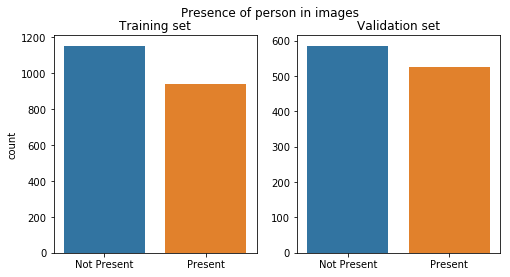

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sns.countplot(y_tr, ax=ax1)
ax1.set_title('Training set', size=12)
ax1.set_xlabel(' ')
ax1.set_xticklabels(['Not Present', 'Present'])
sns.countplot(y_val, ax=ax2)
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_xticklabels(['Not Present', 'Present'])
ax2.set_title('Validation set', size=12)
fig.suptitle('Presence of person in images', size=12)
plt.show()

### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

*Answer: *I chose the DummyClassifier using the 'stratified' strategy, which generates random predictions on the set, by respecting the training set class distribution. This means the classifier will try to keep the same percentage of presence of a person in an image of the training set when classifying the images of the validation set.

In [9]:
# Create a DummyClassifier using the 'stratified' strategy
dummy = DummyClassifier(strategy = 'stratified', random_state = 0)
dummy.fit(X_tr, y_tr)

# Check performance of baseline
print('Accuracy on validation set: {}'.format(dummy.score(X_val, y_val)))

Accuracy on validation set: 0.510332434861


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

In [10]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr.score(X_val, y_val)))

Classification accuracy on training set: 0.551
Classification accuracy on validation set: 0.527


*Answer: * Looking at the classification accuracy of both the training and the validation sets, the classifier performed poorly. Its accuracy is just above the accuracy of the baseline, therefore it requires improvement.

### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [11]:
print('Means:')
print(X_tr.mean(axis = 0)[0:5])
print('Standard deviations:')
print(X_tr.std(axis = 0)[0:5])
X_tr.describe()

Means:
dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64
Standard deviations:
dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64


,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim491,dim492,dim493,dim494,dim495,dim496,dim497,dim498,dim499,dim500
count,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,...,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000
mean,0.001751,0.000756,0.004317,0.001853,0.002272,0.002220,0.001019,0.002446,0.002088,0.002746,...,0.002134,0.000563,0.004586,0.001541,0.003642,0.002200,0.002928,0.002173,0.002485,0.002978
std,0.001193,0.001406,0.003693,0.001340,0.001598,0.001741,0.000873,0.002910,0.001971,0.002328,...,0.001616,0.001203,0.005825,0.001192,0.002657,0.001664,0.003254,0.001418,0.001997,0.002765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000833,0.000000,0.001359,0.000756,0.001116,0.001019,0.000340,0.000625,0.000744,0.001116,...,0.001019,0.000000,0.000679,0.000679,0.001698,0.001019,0.000744,0.001116,0.001019,0.001019
50%,0.001563,0.000340,0.003397,0.001698,0.002038,0.001860,0.000744,0.001563,0.001698,0.002056,...,0.001860,0.000000,0.002717,0.001359,0.003057,0.001860,0.001953,0.002038,0.002038,0.002232
75%,0.002378,0.000893,0.006324,0.002717,0.003057,0.003057,0.001488,0.003397,0.002717,0.003736,...,0.002976,0.000679,0.006454,0.002232,0.004808,0.003057,0.003780,0.002976,0.003397,0.004076
max,0.009851,0.016644,0.027514,0.010789,0.010417,0.021739,0.005774,0.029830,0.028372,0.020380,...,0.010870,0.021739,0.053329,0.010234,0.024457,0.011719,0.028125,0.008492,0.014509,0.028533


### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [12]:
scaler = preprocessing.StandardScaler().fit(X_tr)

scaled_tr = scaler.transform(X_tr)
scaled_val = scaler.transform(X_val)

print('Mean of training set: {}'.format(scaled_tr.mean(axis = 0)[0:5]))
print('Std of training set: {}'.format(scaled_tr.std(axis = 0)[0:5]))
print('Mean of validation set: {}'.format(scaled_val.mean(axis = 0)[0:5]))
print('Std of validation set: {}'.format(scaled_val.std(axis = 0)[0:5]))

Mean of training set: [ -3.39485301e-17  -2.20665446e-17   2.44429417e-16   1.42583827e-16
  -5.77125012e-17]
Std of training set: [ 1.  1.  1.  1.  1.]
Mean of validation set: [-0.00550612 -0.0382933   0.10915098  0.09369314  0.03057844]
Std of validation set: [ 1.01310886  0.96981949  1.0492285   1.05684479  0.97471336]


*Answer: * The transform method of the StandardScaler performs standardization by centering and scaling. Therefore, the standard deviation of the dimensions of the scaled training set is 1, as expected. The mean values are also really small due to scaling. As for the validation set, its standard deviation is close to 1, but not exactly, as the data used to fit the scaler was the training set. For the same reason, the mean is as shown. We didn't use the validation set to standardise the data as it is a smaller set of images.

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [13]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(scaled_tr, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(scaled_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr.score(scaled_val, y_val)))

Classification accuracy on training set: 0.811
Classification accuracy on validation set: 0.643


*Answer: * Looking at the accuracy of the classifier on the transformed data, we see a major improvement on the classification of the training set. The accuracy on the validation is also better than the baseline classifier's performance, but still not ideal for a classifier.

### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [14]:
k_fold = KFold(n_splits = 3, shuffle = True, random_state = 0)
# Show mean values
k = 1
for train_index, test_index in k_fold.split(train_A):
    X_train, X_test = scaled_tr[train_index], scaled_tr[test_index]
    print("Fold {} Number of test samples: {}".format(k, X_test.shape[0]))
    k += 1

Fold 1 Number of test samples: 698
Fold 2 Number of test samples: 698
Fold 3 Number of test samples: 697


### ========== Question 1.12 --- [2 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [15]:
C_range = np.logspace(-5, 5, 20)
Matrix = np.zeros([3,20])
# k_fold iterator
k = 0
for train_index, test_index in k_fold.split(scaled_tr):
    X_train, X_test = scaled_tr[train_index], scaled_tr[test_index]
    x = 0
    for C in C_range:
        lr_fold = LogisticRegression(C = C, solver='lbfgs')
        lr_fold.fit(X_train, y_tr[train_index])
        Matrix[k][x] = lr_fold.score(X_test, y_tr[test_index])
        x += 1
    k += 1

### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

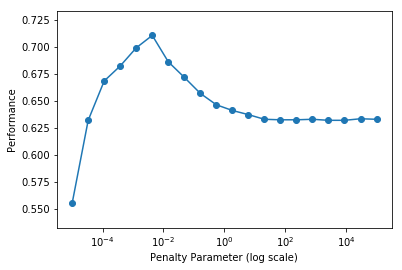

In [16]:
means = np.mean(Matrix, axis = 0)
plt.scatter(C_range, means)
plt.plot(C_range, means)
plt.xscale('log')
plt.ylabel('Performance')
plt.xlabel('Penalty Parameter (log scale)')
plt.show()

### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [17]:
def get_optimal_value(matrix, ranges):
    return ranges[np.argmax(np.mean(matrix, axis = 0))]

In [18]:
optimal = get_optimal_value(Matrix, C_range)
lr_best = LogisticRegression(C = optimal, solver = 'lbfgs')
lr_best.fit(scaled_tr, y_tr)
print('Optimal value: {}'.format(optimal))
print('Classification accuracy on training set: {:.3f}'.format(lr_best.score(scaled_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(lr_best.score(scaled_val, y_val)))

Optimal value: 0.00428133239872
Classification accuracy on training set: 0.780
Classification accuracy on validation set: 0.696


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [19]:
# Use same range and k fold cv. Fit the training set
lrcv = LogisticRegressionCV(Cs = C_range, cv = k_fold, solver = 'lbfgs')
lrcv.fit(scaled_tr, y_tr)
# Optimal value shown by the C_ attribute of LogisticRegressionCV
print('Optimal Value: {}'.format(lrcv.C_))
# Show accuracy on validation set
print('Classification accuracy on validation set: {:.3f}'.format(lrcv.score(scaled_val, y_val)))

Optimal Value: [ 0.00428133]
Classification accuracy on validation set: 0.696


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to the labs if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [20]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(scaled_tr, y_tr)
prediction_tr = rf.predict(X = scaled_tr)
prediction_val = rf.predict(X = scaled_val)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_tr,prediction_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(accuracy_score(y_val,prediction_val)))

Classification accuracy on training set: 1.000
Classification accuracy on validation set: 0.693


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Answer: * As we can see from the accuracy shown above, the random forest classifier performs perfectly when classifying the training set, but its accuracy on the validation set is much less. This is not surprising. The forest built from the training set apparently fit the training data perfectly(overfitting), thus performed poorly on a new set of data, i.e. the validation set.

### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [21]:
def get_importances(rf):
    # Get the feature importances of the model
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    for f in range(50):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [22]:
get_importances(rf)

1. feature 20 (0.007572)
2. feature 50 (0.007559)
3. feature 359 (0.007032)
4. feature 3 (0.006193)
5. feature 478 (0.006054)
6. feature 75 (0.006026)
7. feature 282 (0.005811)
8. feature 460 (0.005606)
9. feature 342 (0.005451)
10. feature 397 (0.004859)
11. feature 347 (0.004783)
12. feature 73 (0.004742)
13. feature 484 (0.004716)
14. feature 355 (0.004702)
15. feature 329 (0.004640)
16. feature 216 (0.004606)
17. feature 262 (0.004577)
18. feature 221 (0.004218)
19. feature 133 (0.004131)
20. feature 499 (0.004064)
21. feature 273 (0.004042)
22. feature 253 (0.004002)
23. feature 205 (0.003890)
24. feature 422 (0.003867)
25. feature 346 (0.003813)
26. feature 16 (0.003728)
27. feature 325 (0.003704)
28. feature 89 (0.003703)
29. feature 91 (0.003701)
30. feature 328 (0.003687)
31. feature 213 (0.003668)
32. feature 321 (0.003613)
33. feature 288 (0.003595)
34. feature 53 (0.003591)
35. feature 439 (0.003581)
36. feature 426 (0.003576)
37. feature 72 (0.003462)
38. feature 34 (0.003

### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [23]:
svc_linear = LinearSVC()
svc_linear.fit(scaled_tr, y_tr)
svc_rbf = SVC(kernel = 'rbf')
svc_rbf.fit(scaled_tr, y_tr)
svc_poly = SVC(kernel = 'poly')
svc_poly.fit(scaled_tr, y_tr)
print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear.score(scaled_tr, y_tr)))
print('Linear SVC classification accuracy on test set: {:.3f}'.format(svc_linear.score(scaled_val, y_val)))
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(scaled_tr, y_tr)))
print('RBF SVC classification accuracy on test set: {:.3f}'.format(svc_rbf.score(scaled_val, y_val)))
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(scaled_tr, y_tr)))
print('Poly SVC classification accuracy on test set: {:.3f}'.format(svc_poly.score(scaled_val, y_val)))

Linear SVC classification accuracy on training set: 0.813
Linear SVC classification accuracy on test set: 0.642
RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on test set: 0.730
Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on test set: 0.702


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [24]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

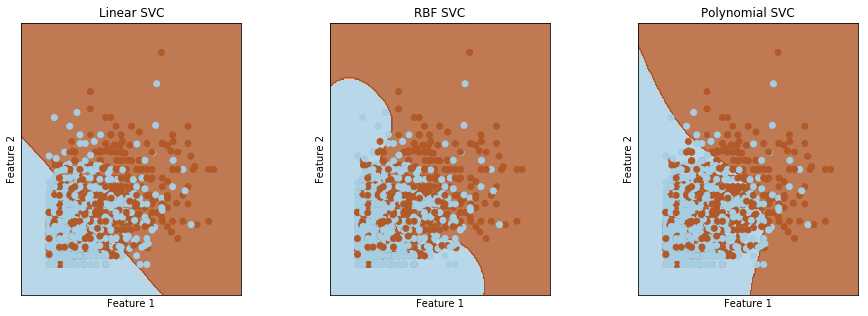

In [25]:
# 2D data
X_tr_21 = scaled_tr[:,20]
X_tr_76 = scaled_tr[:, 75]
X_tr_2D = np.concatenate([X_tr_21[:, None],X_tr_76[:, None]], axis = 1)

# SVMs
svc_linear_2D = LinearSVC()
svc_linear_2D.fit(X_tr_2D, y_tr)

svc_rbf_2D = SVC(kernel = 'rbf')
svc_rbf_2D.fit(X_tr_2D, y_tr)

svc_poly_2D = SVC(kernel = 'poly')
svc_poly_2D.fit(X_tr_2D, y_tr)

# Create a list with the classifiers
clfs = list()
clfs.append(svc_linear_2D)
clfs.append(svc_rbf_2D)
clfs.append(svc_poly_2D)


show_svc_decision_boundaries(clfs, X_tr_2D, title = ['Linear SVC', 'RBF SVC', 'Polynomial SVC'])

In [26]:
# 2D validation set data
X_val_21 = scaled_val[:,20]
X_val_76 = scaled_val[:, 75]
X_val_2D = np.concatenate([X_val_21[:, None],X_val_76[:, None]], axis = 1)

print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_linear_2D.score(X_tr_2D, y_tr)))
print('Linear SVC classification accuracy on validation set: {:.3f}'.format(svc_linear_2D.score(X_val_2D, y_val)))
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf_2D.score(X_tr_2D, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf_2D.score(X_val_2D, y_val)))
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly_2D.score(X_tr_2D, y_tr)))
print('Poly SVC classification accuracy on validation set: {:.3f}'.format(svc_poly_2D.score(X_val_2D, y_val)))

Linear SVC classification accuracy on training set: 0.628
Linear SVC classification accuracy on validation set: 0.624
RBF SVC classification accuracy on training set: 0.636
RBF SVC classification accuracy on validation set: 0.626
Poly SVC classification accuracy on training set: 0.591
Poly SVC classification accuracy on validation set: 0.565


*Answer: * The above decision boundaries are not very clear boundaries for separation of the features. There are a lot of points of both colors in both split sectors. This suggests (and is also confirmed by the accuracies shown above) that the classifiers do not perform very well.

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [61]:
# Specific for RBF kernel
# Can produce results on k-fold and for both penalty parameter range and gamma range
def produce_rbf_svm_classifier(k_fold, tr_set, val_set, target_tr, target_val, type_of_space, space, results, C = 1.0):
    # C space
    if (type_of_space == 'C'):
        k = 0
        for train_index, test_index in k_fold.split(tr_set):
            X_train, X_test = tr_set[train_index], tr_set[test_index]
            x = 0
            for s in space:
                svc_rbf_cv = SVC(C = s, kernel = 'rbf', gamma = 'auto')
                svc_rbf_cv.fit(X_train, target_tr[train_index])
                results[k][x] = svc_rbf_cv.score(X_test, target_tr[test_index])
                x += 1
            k += 1
    # Gamma space
    elif (type_of_space == 'G'):
        k = 0
        for train_index, test_index in k_fold.split(tr_set):
            X_train, X_test = tr_set[train_index], tr_set[test_index]
            x = 0
            for s in space:
                svc_rbf_cv = SVC(C = C, kernel = 'rbf', gamma = s)
                svc_rbf_cv.fit(X_train, target_tr[train_index])
                results[k][x] = svc_rbf_cv.score(X_test, target_tr[test_index])
                x += 1
            k +=1
            
    # Plot accuracy
    means = np.mean(results, axis = 0)
    plt.scatter(space, means)
    plt.plot(space, means)
    plt.xscale('log')
    plt.ylabel('Performance')
    if (type_of_space == 'C'):
        plt.xlabel('Penalty Parameter (log scale)')
    elif (type_of_space == 'G'):
        plt.xlabel('Kernel coefficient (log scale)')
    plt.show()

    # Train the classifier with optimal value depending on which space we chose to vary
    opt_value = get_optimal_value(results, space)
    if (type_of_space == 'C'):
        svc = SVC(C = opt_value, kernel = 'rbf', gamma = 'auto')
    elif (type_of_space == 'G'):
        svc = SVC(C = C, kernel = 'rbf', gamma = opt_value)
    
    # Fit the training set
    svc.fit(tr_set, target_tr)
    
    print('Optimal value: {}'.format(opt_value))
    print('Classification accuracy on training set: {:.3f}'.format(svc.score(tr_set, target_tr)))
    print('Classification accuracy on test set: {:.3f}'.format(svc.score(val_set, target_val)))

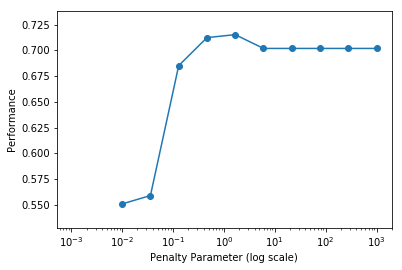

Optimal value: 1.6681005372
Classification accuracy on training set: 0.975
Classification accuracy on test set: 0.728


In [28]:
results = np.zeros([3,10])
C_range = np.logspace(-2, 3, 10)

produce_rbf_svm_classifier(k_fold, scaled_tr, scaled_val, y_tr, y_val, 'C', C_range, results)

### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

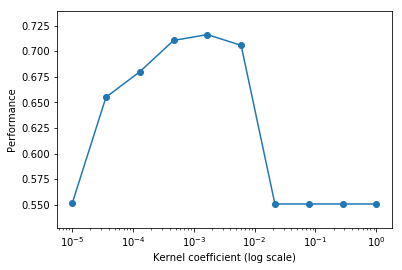

Optimal value: 0.0016681005372
Classification accuracy on training set: 0.891
Classification accuracy on test set: 0.727


In [29]:
results_g = np.zeros([3,10])
gamma_range = np.logspace(-5, 0, 10)

produce_rbf_svm_classifier(k_fold, scaled_tr, scaled_val, y_tr, y_val, 'G', gamma_range, results_g)

### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [30]:
# Different procedure for pairs of C and G
C_space = np.logspace(-2, 1, 4)
gamma_space = np.logspace(-4, -1, 4)
pairs_results = np.zeros([3,4,4])

# Use the k_fold specified earlier
k = 0
for train_index, test_index in k_fold.split(scaled_tr):
    X_train, X_test = scaled_tr[train_index], scaled_tr[test_index]
    i = 0
    for C in C_space:
        j = 0
        for g in gamma_space:
            svc_rbf_cv = SVC(C = C, kernel = 'rbf', gamma = g)
            svc_rbf_cv.fit(X_train, y_tr[train_index])
            pairs_results[k][j][i] = svc_rbf_cv.score(X_test, y_tr[test_index])
            j += 1
        i += 1
    k +=1

Optimal C: 1.0
Optimal gamma: 0.001
Classification accuracy on training set: 0.835
Classification accuracy on test set: 0.721


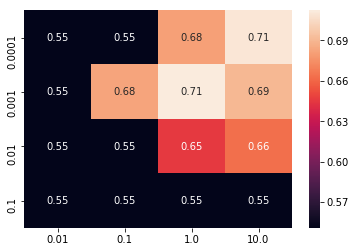

In [31]:
# Produce heatmap
mean_perf = np.mean(pairs_results, axis = 0)
sns.heatmap(mean_perf, xticklabels=C_space, yticklabels=gamma_space, annot=True)

# Converts to a tuple coordinate to get the optimal values from each space
opt = np.unravel_index(mean_perf.argmax(), mean_perf.shape)

opt_c = C_space[opt[1]]
opt_g = gamma_space[opt[0]]

print('Optimal C: {}'.format(opt_c))
print('Optimal gamma: {}'.format(opt_g))

# Train classifier
svc_rbf_cv_best = SVC(C = opt_c, kernel = 'rbf', gamma = opt_g)
svc_rbf_cv_best.fit(scaled_tr, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(svc_rbf_cv_best.score(scaled_tr, y_tr)))
print('Classification accuracy on test set: {:.3f}'.format(svc_rbf_cv_best.score(scaled_val, y_val)))

### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Answer: * The classification accuracy on the validation set is slightly lower than in previous questions. For question 1.21, we set the gamma to auto and found that the optimal value was 1.668 and for question 1.22, we set C to 1.0 and found that the optimal value was 0.001668. For both questions we split our range into more values, therefore, more iterations took place and better solutions were found. When testing the pairs, we used a smaller range for both C and gamma and concluded to 1.0 and 0.001. We could use a bigger range to improve the performance and find better optimal values pairs. Of course this computation will be more expensive and time-consuming.

### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

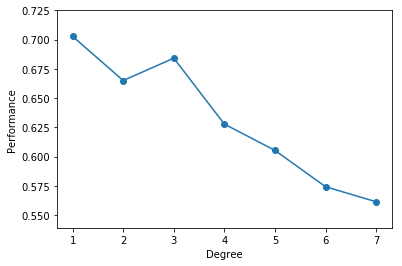

Optimal value: 1
Classification accuracy on training set: 0.784
Classification accuracy on test set: 0.689


In [32]:
results_degree = np.zeros([3,7])
degree_range = np.arange(1,8)

# Use the k_fold specified earlier
k = 0
for train_index, test_index in k_fold.split(scaled_tr):
    X_train, X_test = scaled_tr[train_index], scaled_tr[test_index]
    x = 0
    for d in degree_range:
        svc_poly = SVC(kernel = 'poly', degree = d)
        svc_poly.fit(X_train, y_tr[train_index])
        results_degree[k][x] = svc_poly.score(X_test, y_tr[test_index])
        x += 1
    k +=1
    
# Plot accuracy
means = np.mean(results_degree, axis = 0)
plt.scatter(degree_range, means)
plt.plot(degree_range, means)
plt.ylabel('Performance')
plt.xlabel('Degree')
plt.show()

# Train the classifier with optimal value depending on which space we chose to vary
opt_value = get_optimal_value(results_degree, degree_range)
svc_opt = SVC(kernel = 'poly', degree = opt_value)

# Fit the training set
svc_opt.fit(scaled_tr, y_tr)

print('Optimal value: {}'.format(opt_value))
print('Classification accuracy on training set: {:.3f}'.format(svc_opt.score(scaled_tr, y_tr)))
print('Classification accuracy on test set: {:.3f}'.format(svc_opt.score(scaled_val, y_val)))

### ========== Question 1.26 --- [4 marks] ==========

You might have noticed that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Answer: * Both validation methods have pros and cons and although we had a validation set we chose not to use the hold-out validation method. 

Having independent training and test sets is the advantage of using the hold-out validation method. This splitting of the data into the two sets avoids the overlap between the two sets, thus producing a more accurate representation of the performance of the classifier used. On the other side, splitting the data means we have reduced data for both training and testing.

Using the cross-validation method, we get a more accurate estimation of the classifier's performance, as we are splitting the data k times and measure the classifier's performance on each fold. The downside is the training and test data overlap each time.

In practice, I would trust more the cross-validation method, because essentially it's like a repeated hold-out validation but instead of using separate training and test sets, each time we estimate accuracy on the split of the data. This can potentially improve the classifier, as data points are used in both training and testing.

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briefly explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [33]:
full_X_tr = train_A.drop(['imgId', 'is_person'], axis = 1)
full_y_tr = train_A['is_person']
full_X_val = valid_A.drop(['imgId', 'is_person'], axis = 1)
full_y_val = valid_A['is_person']
print('Train Images: Number of instances: {}, number of attributes: {}'.format(full_X_tr.shape[0], full_X_tr.shape[1]))
print('Valid Images: Number of instances: {}, number of attributes: {}'.format(full_X_val.shape[0], full_X_val.shape[1]))

Train Images: Number of instances: 2093, number of attributes: 518
Valid Images: Number of instances: 1113, number of attributes: 518


In [34]:
# Standardise features
full_scaler = preprocessing.StandardScaler().fit(full_X_tr)

full_scaled_tr = full_scaler.transform(full_X_tr)
full_scaled_val = full_scaler.transform(full_X_val)

print('Mean of training set: {}'.format(full_scaled_tr.mean(axis = 0)[0:5]))
print('Std of training set: {}'.format(full_scaled_tr.std(axis = 0)[0:5]))
print('Mean of validation set: {}'.format(full_scaled_val.mean(axis = 0)[0:5]))
print('Std of training set: {}'.format(full_scaled_val.std(axis = 0)[0:5]))

Mean of training set: [ -3.39485301e-17  -2.20665446e-17   2.44429417e-16   1.42583827e-16
  -5.77125012e-17]
Std of training set: [ 1.  1.  1.  1.  1.]
Mean of validation set: [-0.00550612 -0.0382933   0.10915098  0.09369314  0.03057844]
Std of training set: [ 1.01310886  0.96981949  1.0492285   1.05684479  0.97471336]


In [35]:
# Train the Random Forest Classifier
rf_full = RandomForestClassifier(n_estimators = 500, random_state = 31, criterion='entropy')
rf_full.fit(full_scaled_tr, full_y_tr)
prediction_full_tr = rf_full.predict(X = full_scaled_tr)
prediction_full_val = rf_full.predict(X = full_scaled_val)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(full_y_tr, prediction_full_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(accuracy_score(full_y_val, prediction_full_val)))

Classification accuracy on training set: 1.000
Classification accuracy on validation set: 0.712


In [36]:
get_importances(rf_full)

1. feature 507 (0.009379)
2. feature 502 (0.008731)
3. feature 20 (0.008030)
4. feature 50 (0.005925)
5. feature 359 (0.005463)
6. feature 3 (0.005325)
7. feature 75 (0.005271)
8. feature 397 (0.005254)
9. feature 282 (0.004983)
10. feature 478 (0.004942)
11. feature 262 (0.004734)
12. feature 342 (0.004609)
13. feature 422 (0.004433)
14. feature 484 (0.004245)
15. feature 253 (0.004189)
16. feature 460 (0.004158)
17. feature 221 (0.004134)
18. feature 355 (0.003914)
19. feature 73 (0.003860)
20. feature 287 (0.003850)
21. feature 213 (0.003792)
22. feature 347 (0.003781)
23. feature 329 (0.003713)
24. feature 216 (0.003683)
25. feature 482 (0.003633)
26. feature 89 (0.003626)
27. feature 273 (0.003597)
28. feature 346 (0.003533)
29. feature 16 (0.003448)
30. feature 426 (0.003377)
31. feature 34 (0.003306)
32. feature 325 (0.003298)
33. feature 72 (0.003267)
34. feature 311 (0.003193)
35. feature 47 (0.003160)
36. feature 24 (0.003155)
37. feature 314 (0.003146)
38. feature 321 (0.003

*Answer: * Looking at the list of the best 50 features, we can see that the first two best features are features 502 and 507. These are class indicator variables 'is_bicycle' and 'is_car', instead of being dim features. As the list goes on, we notice that the rest is almost identical to the important features of the previous forest classifier.

The accuracy of this classifier is slightly improved on the validation set, but we can still see that the forest overfits on the training data.

Looking at the actual images, a lot of them contain cars, therefore as the classifier overfits on the training set, it predicts cars to be in the test set, correctly or not.

It wouldn't be easy to make use of the results, because on a new test set we wouldn't have information on the class attributes, therefore we wouldn't be able to classify the data.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see the labs). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

*Answer: *
We were provided with three sets, which were loaded into three individual panda DataFrames. Looking at the data, we notice they are very similar with the ones used in the previous question, i.e. having 500 dim features, an ID and 19 class attributes. We are again interested in the ‘is_person’ class attribute. Therefore, the next step was to create two other DataFrames for the training and validation set, only including the 500 dim features. We applied feature standardisation on the data to avoid abnormal behavior of the classifiers to be used later on. The data was transformed to have zero mean and unit variance, which is an important assumption of Support Vector Machines. This scaled data was used throughout the task. 

The first trial done was with the Logistic Regression classifier using the ‘lbfgs’ solver. As we have a binary classification task and the assumption that  the data is independent and identically distributed, the classifier finds the maximum likelihood of each piece of data. The classifier didn’t perform very well, having a log loss of 0.663 on the validation set.

Then, using 3-Fold cross-validation, the Logistic Regression classifier performed better, reaching a log loss of 0.584 on the validation set. The 3-Fold CV was used to optimise the regularisation parameter of the classifier and use that optimal value to check its performance on the validation set.

Looking at the previous questions on the train_A data, we can see that SVM classifiers perform better. Therefore, trying out the SVM with the RBF kernel seemed like a good idea. Trying that though, the accuracy on both training and validation sets was surprisingly low. Loss loss was also quite high at 0.693. The RBF kernel checks the squared Euclidean distance between feature vectors and acts as a similarity measure because the smaller the value the smaller the distance between the features, .i.e. they are more similar.

As the previous attempt failed, the next choice was to use a 3-Fold CV on the SVM with RBF kernel, altering the penalty parameter in the log range (2, 8). The optimal value of the penalty parameter was found and the performance of the classifier was better. Its log loss is slightly lowered, which is still not ideal.

Trying to achieve greater accuracy, the Random Forest Classifier was used on the scaled data. Its log loss was the lowest, being 0.583, and its accuracy was the highest on the validation set, at 0.701. Its high accuracy of 1.0 on the training set was not considered when choosing it to be the “best” classifier for the task, because, as this was explained in previous questions as well, the classifier seemed to overfit on the training data. 

Therefore, the Random Forest Classifier was used on pre-processed data (feature standardised) to get the lowest log loss and highest accuracy out of all classifiers. It was used on the test set to return the probabilities for each class, which were submitted as a text file as well.

Note: Out of curiosity I used the Random Forest Classifier with the training and validation set containing the class attributes as well (again pre-processed). Its accuracy on the training set is again 1.0 as expected and on the validation set 0.725. Of course this classifier cannot be used on the test set as we do not have values for the class attributes.


In [37]:
# Load training, validation and test sets
data_path_train_B = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path_train_B, delimiter = ',')

data_path_valid_B = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path_valid_B, delimiter = ',')

data_path_test = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path_test, delimiter = ',')

print('Train Images: Number of instances: {}, number of attributes: {}'.format(train_B.shape[0], train_B.shape[1]))
print('Valid Images: Number of instances: {}, number of attributes: {}'.format(valid_B.shape[0], valid_B.shape[1]))
print('Test Images: Number of instances: {}, number of attributes: {}'.format(test_B.shape[0], test_B.shape[1]))

Train Images: Number of instances: 2113, number of attributes: 520
Valid Images: Number of instances: 1113, number of attributes: 520
Test Images: Number of instances: 1114, number of attributes: 501


In [38]:
# Get the 500 dim
X_tr_B = train_B[X]
X_val_B = valid_B[X]
y_tr_B = train_B['is_person']
y_val_B = valid_B['is_person']
print('X_tr shape: {}'.format(X_tr_B.shape))
print('X_val shape: {}'.format(X_val_B.shape))
print('y_tr shape: {}'.format(y_tr_B.shape))
print('y_val shape: {}'.format(y_val_B.shape))

X_tr shape: (2113, 500)
X_val shape: (1113, 500)
y_tr shape: (2113,)
y_val shape: (1113,)


In [39]:
# Scale data
scaler_B = preprocessing.StandardScaler().fit(X_tr_B)

scaled_tr_B = scaler_B.transform(X_tr_B)
scaled_val_B = scaler_B.transform(X_val_B)

print('Mean of training set: {}'.format(scaled_tr_B.mean(axis = 0)[0:5]))
print('Std of training set: {}'.format(scaled_tr_B.std(axis = 0)[0:5]))
print('Mean of validation set: {}'.format(scaled_val_B.mean(axis = 0)[0:5]))
print('Std of training set: {}'.format(scaled_val_B.std(axis = 0)[0:5]))

Mean of training set: [ -1.34508800e-17   8.40680000e-18   2.10170000e-18  -4.20340000e-18
  -3.36272000e-18]
Std of training set: [ 1.  1.  1.  1.  1.]
Mean of validation set: [-0.08108676 -0.08602643 -0.08975741 -0.07628021 -0.08358007]
Std of training set: [ 0.00235501  0.00234014  0.00803716  0.00304919  0.0031713 ]


In [44]:
# Logistic Regression trial
lr_B = LogisticRegression(solver='lbfgs')
lr_B.fit(scaled_tr_B, y_tr_B)
# Log loss metric
probs_lr_B = lr_B.predict_proba(scaled_val_B)
ll_lr_B = log_loss(y_val_B, probs_lr_B)
print('Log loss on validation set: {:.3f}'.format(ll_lr_B))

print('Classification accuracy on training set: {:.3f}'.format(lr_B.score(scaled_tr_B, y_tr_B)))
print('Classification accuracy on validation set: {:.3f}'.format(lr_B.score(scaled_val_B, y_val_B)))


Log loss on validation set: 0.663
Classification accuracy on training set: 0.622
Classification accuracy on validation set: 0.607


In [45]:
C_range = np.logspace(-5, 5, 20)
# Use same range and k fold cv. Fit the training set
lrcv_B = LogisticRegressionCV(Cs = C_range, cv = k_fold, solver = 'lbfgs')
lrcv_B.fit(scaled_tr_B, y_tr_B)

# Log loss metric
probs_lrcv_B = lrcv_B.predict_proba(scaled_val_B)
ll_lrcv_B = log_loss(y_val_B, probs_lrcv_B)
print('Log loss on validation set: {:.3f}'.format(ll_lrcv_B))

# Optimal value shown by the C_ attribute of LogisticRegressionCV
print('Optimal Value: {}'.format(lrcv_B.C_))
print('Classification accuracy on training set: {:.3f}'.format(lrcv_B.score(scaled_tr_B, y_tr_B)))
# Show accuracy on validation set
print('Classification accuracy on validation set: {:.3f}'.format(lrcv_B.score(scaled_val_B, y_val_B)))

Log loss on validation set: 0.584
Optimal Value: [ 233.57214691]
Classification accuracy on training set: 0.764
Classification accuracy on validation set: 0.689


In [51]:
# SVM with rbf kernel
svc_rbf_B = SVC(kernel = 'rbf', probability = True)
svc_rbf_B.fit(scaled_tr_B, y_tr_B)

# Log loss metric
probs_svc_B = svc_rbf_B.predict_proba(scaled_val_B)
ll_svc_B = log_loss(y_val_B, probs_svc_B)
print('Log loss on validation set: {:.3f}'.format(ll_svc_B))

print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf_B.score(scaled_tr_B, y_tr_B)))
print('RBF SVC classification accuracy on test set: {:.3f}'.format(svc_rbf_B.score(scaled_val_B, y_val_B)))

Log loss on validation set: 0.693
RBF SVC classification accuracy on training set: 0.555
RBF SVC classification accuracy on test set: 0.527


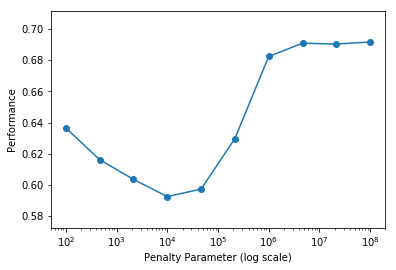

Optimal value: 100000000.0
Log loss on validation set: 0.692
Classification accuracy on training set: 0.787
Classification accuracy on test set: 0.628


In [68]:
# K-fold SVM with rbf kernel
results_B = np.zeros([3,10])
C_range = np.logspace(2, 8, 10)

# Do the k-fold and iterate on range for Penalty parameter
# but this time check log loss to find optimal value

k = 0
for train_index, test_index in k_fold.split(scaled_tr_B):
    X_train, X_test = scaled_tr_B[train_index], scaled_tr_B[test_index]
    x = 0
    for s in C_range:
        svc_rbf_cv = SVC(C = s, kernel = 'rbf', gamma = 'auto', probability = True)
        svc_rbf_cv.fit(X_train, y_tr_B[train_index])
        probs_svc = svc_rbf_cv.predict_proba(scaled_val_B)
        ll_svc_B = log_loss(y_val_B, probs_svc)
        results_B[k][x] = ll_svc_B
        x += 1
    k += 1
    
# Plot accuracy
means = np.mean(results_B, axis = 0)
plt.scatter(C_range, means)
plt.plot(C_range, means)
plt.xscale('log')
plt.ylabel('Performance')
plt.xlabel('Penalty Parameter (log scale)')
plt.show()

# Train the classifier with optimal value depending on which space we chose to vary
opt_value = get_optimal_value(results_B, C_range)
svc = SVC(C = opt_value, kernel = 'rbf', gamma = 'auto', probability = True)

# Fit the training set
svc.fit(scaled_tr_B, y_tr_B)

print('Optimal value: {}'.format(opt_value))

# Log loss metric
probs_svc = svc.predict_proba(scaled_val_B)
ll_svc = log_loss(y_val_B, probs_svc)
print('Log loss on validation set: {:.3f}'.format(ll_svc))

print('Classification accuracy on training set: {:.3f}'.format(svc.score(scaled_tr_B, y_tr_B)))
print('Classification accuracy on test set: {:.3f}'.format(svc.score(scaled_val_B, y_val_B)))

In [59]:
# Random Forest Classifier on scaled data
rf_B = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_B.fit(scaled_tr_B, y_tr_B)
prediction_tr_B = rf_B.predict(X = scaled_tr_B)
prediction_val_B = rf_B.predict(X = scaled_val_B)

# Log loss metric
probs_rf_B = rf_B.predict_proba(scaled_val_B)
ll_rf_B = log_loss(y_val_B, probs_rf_B)
print('Log loss on validation set: {:.3f}'.format(ll_rf_B))

print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_tr_B, prediction_tr_B)))
print('Classification accuracy on validation set: {:.3f}'.format(accuracy_score(y_val_B, prediction_val_B)))

Log loss on validation set: 0.583
Classification accuracy on training set: 1.000
Classification accuracy on validation set: 0.701


In [53]:
# Get dims as well as class attributes in the training and validation sets
full_X_tr_B = train_B.drop(['imgId', 'is_person'], axis = 1)
full_y_tr_B = train_B['is_person']
full_X_val_B = valid_B.drop(['imgId', 'is_person'], axis = 1)
full_y_val_B = valid_B['is_person']
print('Train Images: Number of instances: {}, number of attributes: {}'.format(full_X_tr_B.shape[0], full_X_tr_B.shape[1]))
print('Valid Images: Number of instances: {}, number of attributes: {}'.format(full_X_val_B.shape[0], full_X_val_B.shape[1]))

Train Images: Number of instances: 2113, number of attributes: 518
Valid Images: Number of instances: 1113, number of attributes: 518


In [60]:
# Scale full data
full_scaler_B = preprocessing.StandardScaler().fit(full_X_tr_B)

full_scaled_tr_B = full_scaler.transform(full_X_tr_B)
full_scaled_val_B = full_scaler.transform(full_X_val_B)

# Random Forest Classifier on 518-D data
rf_full_B = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_full_B.fit(full_X_tr_B, full_y_tr_B)
prediction_tr_full_B = rf_full_B.predict(X = full_X_tr_B)
prediction_val_full_B = rf_full_B.predict(X = full_X_val_B)

# Log loss metric
probs_rf_full_B = rf_full_B.predict_proba(full_scaled_val_B)
ll_rf_full_B = log_loss(y_val_B, probs_rf_full_B)
print('Log loss on validation set: {:.3f}'.format(ll_rf_full_B))

print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(full_y_tr_B, prediction_tr_full_B)))
print('Classification accuracy on validation set: {:.3f}'.format(accuracy_score(full_y_val_B, prediction_val_full_B)))

Log loss on validation set: 0.689
Classification accuracy on training set: 1.000
Classification accuracy on validation set: 0.725


In [66]:
# Scale test data
X_test = test_B.drop('is_person', axis = 1)
scaler_test = preprocessing.StandardScaler().fit(X_test)

scaled_test = scaler_test.transform(X_test)

# Get proba array for our best classifier on the test set (RandomForest)
probs_test_B = rf_B.predict_proba(scaled_test)
probs_test_B.shape

(1114, 2)

In [67]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(probs_test_B) 

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)